# Dust Snapshot Checklist
This notebook will put a snapshot through its paces, checking the outputs from FIRE simulations run with my dust evolution models.
It checks for unphysical values and creates plots of dust, gas, and stellar properties to be checked by eye. I mainly use this notebook for sanity checks when testing simulations and is best used as a first once over.

In [22]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from crc_scripts import config
from crc_scripts.figure import Figure,Projection
from crc_scripts.io.gizmo import *
from crc_scripts.utils.math_utils import *
from crc_scripts.io.AHF import AHF
import crc_scripts.utils.data_calc_utils as calc

# First setup directory for all the plots
plot_dir = '~/snap_checklist_plots/'
os.makedirs(plot_dir, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specify the snapshots
Set which simulations you want to check the snapshots along with a prefix for the name of the files to be saved.

In [40]:
# Name prefix for all saved images. Useful if you run this for multiple sims.
prefix=['no_integration']

main_dirc = '/N/scratch/cchoban/dust_integration_tests/'
# Names of simulation directories
sim_names = np.array(['new_full_integration'])

# Snapshot to check
snap_num = 500

# Main sim directories and their snap and halo directories
# Default sim layout is assumed
# Note you need to specify the dtype or else you get numpy strings which annoying to deal with
main_dirs = np.array([main_dirc+name+'/' for name in sim_names], dtype=object)
snap_dirs = np.array([main_dirc+name+'/output/' for name in sim_names], dtype=object)
hdirs = np.array([main_dirc+name+'/halo/ahf/output/' for name in sim_names], dtype=object)
# We only look at the main halos
halo_histories = np.array([main_dirc+name+'/halo/ahf/history/halo_main.dat' for name in sim_names], dtype=object)

## Sanity check values
This checks dust values in snapshots for unphysical values and inconsistencies

In [17]:
for j,snap_dir in enumerate(snap_dirs):
    print("Snap Dirc: ",snap_dir)
    print("Snap Num:",snap_num)
    name = sim_names[j]
    hdir = hdirs[j]
    name_prefix = plot_dir+name+'_'+str(snap_num)

    sp = load_snap(snap_dir, snap_num)
    galaxies += [sp]


    print("NumParts:", sp.npart)
    print("Number of Metal Elements:",sp.Flag_Metals)
    print("Number of Dust Species:",sp.Flag_DustSpecies)
    if sp.Flag_DustSpecies == 0:
        print("This snapshot wasn't run with a dust evolution model so nothing to do here.")
    else:
        G=sp.loadpart(0)
        nH = G.get_property('nH')
        T = G.get_property('T')

        print("Total Dust Mass")
        print(np.sum(G.dz[:,0]*G.m,axis=0))
        print("Dust Source Masses")
        source_masses = np.sum(G.dzs*G.dz[:,0,np.newaxis]*G.m[:,np.newaxis],axis=0)
        for i,source in enumerate(config.DUST_SOURCES):
            print('\t',source, source_masses[i])
        print("Dust Species Mass")
        species_masses = np.sum(G.spec*G.m[:,np.newaxis],axis=0)
        for i in range(sp.Flag_DustSpecies):
            print('\t',config.DUST_SPECIES[i], species_masses[i])



        print("*****************************************************")
        print("First check all particles in snapshot for any issues")
        print("*****************************************************")

        print("\n########################################\n")

        print("Checking for Nans...\n")
        nan_ind = np.argwhere(np.isnan(G.dz).any(axis=1) | np.isnan(G.dzs).any(axis=1) | np.isnan(G.spec).any(axis=1)).flatten()

        if len(nan_ind) > 0:
            print("%i particles with NaNs detected"%len(nan_ind))
            print("Dust Metals:",G.dz[nan_ind])
            print("Species:",G.spec[nan_ind])
            print("Sources:",G.dzs[nan_ind])
            print("nH:", nH[nan_ind])
            print("T:", T[nan_ind])

        print("########################################\n")

        print("Checking for negative numbers...\n")
        neg_ind = np.argwhere(np.logical_or(np.any(G.dz<0,axis=1),np.any(G.dzs<0,axis=1),np.any(G.spec<0,axis=1)))
        if len(neg_ind) > 0:
            print("%i particles with negative numbers detected"%len(neg_ind))
            print("Dust Metals:",G.dz[neg_ind])
            print("Species:",G.spec[neg_ind])
            print("Sources:",G.dzs[neg_ind])
            print("nH:", nH[neg_ind])
            print("T:", T[neg_ind])


        print("########################################\n")

        print("Checking for too much dust compared to metals...\n")
        over_ind = np.argwhere(np.any(G.dz>G.z[:,:11],axis=1)).flatten()
        if len(over_ind) > 0:
            print("%i particles with too much dust detected"%len(over_ind))
            print("Metals:",G.z[over_ind,:11])
            print("D/Z:",G.dz[over_ind]/G.z[over_ind,:11])
            print("Species:",G.spec[over_ind])
            print("Sources:",G.dzs[over_ind])
            print("nH:", nH[over_ind])
            print("T:", T[over_ind])
            print("\t fH2:",G.fH2[over_ind])
            print("\t fdense:",G.fdense[over_ind])
            print("\t CinCO:",G.CinCO[over_ind]/G.z[over_ind,2],"\n")


        print("########################################\n")

        print("Checking dust metals and dust species add up...\n")
        # Maximum allowed error between species and dust metals
        abs_error = 1E-2
        # Min DZ and Z to look for error. Helps avoid vanishingly small amounts of dust which are prone
        # to precision errors
        min_DZ = 1E-2
        min_Z = 1E-4
        # Add up the elements from each dust species
        dust_metals = np.zeros(np.shape(G.dz))
        sil_num_atoms = [3.631,1.06,1.,0.571] # O, Mg, Si, Fe
        sil_elems_index = [4,6,7,10] # O,Mg,Si,Fe
        dust_formula_mass = 0


        print("%i dust species detected."%sp.Flag_DustSpecies)
        if sp.Flag_DustSpecies==4:
            print("Assuming silicates, carbonaceous, SiC, and free-flying metallic iron...\n")
            # Silicates
            for k in range(len(sil_num_atoms)):
                dust_formula_mass += sil_num_atoms[k] * config.ATOMIC_MASS[sil_elems_index[k]]
            for k in range(len(sil_num_atoms)):
                dust_metals[:,sil_elems_index[k]] += G.spec[:,0] * sil_num_atoms[k] * config.ATOMIC_MASS[sil_elems_index[k]] / dust_formula_mass

            # Carbon
            dust_metals[:,2] += G.spec[:,1]

            # Silicon Carbide
            dust_formula_mass = config.ATOMIC_MASS[2] + config.ATOMIC_MASS[7]
            dust_metals[:,2] += G.spec[:,2] * config.ATOMIC_MASS[2] / dust_formula_mass
            dust_metals[:,7] += G.spec[:,2] * config.ATOMIC_MASS[7] / dust_formula_mass

            # Iron
            dust_metals[:,10] += G.spec[:,3]

        elif sp.Flag_DustSpecies==5:
            print("Assuming silicates, carbonaceous, SiC, free-flying metallic iron, and oxygen reservoir...\n")
            # Silicates
            for k in range(len(sil_num_atoms)):
                dust_formula_mass += sil_num_atoms[k] * config.ATOMIC_MASS[sil_elems_index[k]]
            for k in range(len(sil_num_atoms)):
                dust_metals[:,sil_elems_index[k]] += G.spec[:,0] * sil_num_atoms[k] * config.ATOMIC_MASS[sil_elems_index[k]] / dust_formula_mass

            # Carbon
            dust_metals[:,2] += G.spec[:,1]

            # Silicon Carbide
            dust_formula_mass = config.ATOMIC_MASS[2] + config.ATOMIC_MASS[7]
            dust_metals[:,2] += G.spec[:,2] * config.ATOMIC_MASS[2] / dust_formula_mass
            dust_metals[:,7] += G.spec[:,2] * config.ATOMIC_MASS[7] / dust_formula_mass

            # Iron
            dust_metals[:,10] += G.spec[:,3]

            # Oxygen Reservoir
            dust_metals[:,4] += G.spec[:,4]

        elif sp.Flag_DustSpecies==6:
            print("Assuming silicates, carbonaceous, SiC, free-flying metallic iron, oxygen reservoir, and metallic iron inclusions...\n")
            # Iron in silicates comes in the form of a separate dust species 'iron inclusions'
            sil_num_atoms = [3.631,1.06,1.] # O, Mg, Si, Fe
            sil_elems_index = [4,6,7] # O,Mg,Si,Fe

            # Silicates
            for k in range(len(sil_num_atoms)):
                dust_formula_mass += sil_num_atoms[k] * config.ATOMIC_MASS[sil_elems_index[k]]
            for k in range(len(sil_num_atoms)):
                dust_metals[:,sil_elems_index[k]] += G.spec[:,0] * sil_num_atoms[k] * config.ATOMIC_MASS[sil_elems_index[k]] / dust_formula_mass

            # Carbon
            dust_metals[:,2] += G.spec[:,1]

            # Silicon Carbide
            dust_formula_mass = config.ATOMIC_MASS[2] + config.ATOMIC_MASS[7]
            dust_metals[:,2] += G.spec[:,2] * config.ATOMIC_MASS[2] / dust_formula_mass
            dust_metals[:,7] += G.spec[:,2] * config.ATOMIC_MASS[7] / dust_formula_mass

            # Free-Flying Iron and Iron Inclusions
            dust_metals[:,10] += G.spec[:,3] + G.spec[:,5]

            # Oxygen Reservoir
            dust_metals[:,4] += G.spec[:,4]

        else:
            print("\t Number of dust species not supported for this check:",sp.Flag_DustSpecies)

        dust_metals[:,0]=np.sum(dust_metals[:,2:],axis=1)
        bad_ind = np.logical_and(np.any(~np.isclose(G.dz, dust_metals, rtol=abs_error, atol=0,equal_nan=True),axis=1),G.dz[:,0]/G.z[:,0]>min_DZ)
        bad_ind = np.argwhere(np.logical_and(bad_ind,G.z[:,0]>min_Z*config.SOLAR_Z)).flatten()
        if len(bad_ind) > 0:
            print("%i particles with D/Z>%f and Z>%f Z_solar and element and species not matching by %f%% "%(len(bad_ind),min_DZ,min_Z,abs_error*100))
            print("Dust Metals:",G.dz[bad_ind])
            print("Dust Metals from Species:",dust_metals[bad_ind])
            print("D/Z:",G.dz[bad_ind]/G.z[bad_ind,:11])
            print("Species:",G.spec[bad_ind])
            print("Sources:",G.dzs[bad_ind])
            print("nH:", nH[bad_ind])
            print("T:", T[bad_ind])
            print("\t fH2:",G.fH2[bad_ind])
            print("\t fdense:",G.fdense[bad_ind])
            print("\t CinCO:",G.CinCO[bad_ind]/G.z[bad_ind,2],"\n")
            print("\t Sum of Species::",np.sum(G.spec[bad_ind],axis=1))
            print("\t Sum of Elements:",np.sum(G.dz[bad_ind,2:],axis=1))
            print("\t Total Dust:",G.dz[bad_ind,0])
        else:
            print("No particles with D/Z>%f, Z>%f Z_solar, and element and species not matching by %f%% \n"%(min_DZ,min_Z,abs_error*100))


        print("########################################\n")

        print("Sanity Checks...\n")

        print("Particle with Max Dust Mass...")
        max_ind = np.nanargmax(G.dz[:,0])
        print("\t D/Z:",G.dz[max_ind]/G.z[max_ind,:11])
        print("\t Dust Metals:",G.dz[max_ind])
        print("\t Metals:",G.z[max_ind])
        print("\t Species:",G.spec[max_ind])
        print("\t Sources:",G.dzs[max_ind])
        print("\t nH:", nH[max_ind])
        print("\t T:", G.T[max_ind])
        print("\t Sum of Species: %e \t Sum of Elements: %e Total Dust: %e\n"%(np.sum(G.spec[max_ind]),np.sum(G.dz[max_ind,2:]),G.dz[max_ind,0]))
        print("\t fH2: %e \t fdense: %e \t CinCO: %e \n"%(G.fH2[max_ind],G.fdense[max_ind],G.CinCO[max_ind]/G.z[max_ind,2]))


        print("Particle with Max fdense...")
        max_ind = np.nanargmax(G.fdense)
        print("\t D/Z:",G.dz[max_ind]/G.z[max_ind,:11])
        print("\t Dust Metals:",G.dz[max_ind])
        print("\t Metals:",G.z[max_ind])
        print("\t Species:",G.spec[max_ind])
        print("\t Sources:",G.dzs[max_ind])
        print("\t nH:", nH[max_ind])
        print("\t T:", G.T[max_ind])
        print("\t Sum of Species: %e \t Sum of Elements: %e Total Dust: %e\n"%(np.sum(G.spec[max_ind]),np.sum(G.dz[max_ind,2:]),G.dz[max_ind,0]))
        print("\t fH2: %e \t fdense: %e \t CinCO: %e \n"%(G.fH2[max_ind],G.fdense[max_ind],G.CinCO[max_ind]/G.z[max_ind,2]))


        if sp.Flag_DustSpecies>4:
            print("Particle with Max O Reservoir...")
            max_ind = np.nanargmax(G.spec[:,4])
            print("\t D/Z:",G.dz[max_ind]/G.z[max_ind,:11])
            print("\t Dust Metals:",G.dz[max_ind])
            print("\t Metals:",G.z[max_ind])
            print("\t Species:",G.spec[max_ind])
            print("\t Sources:",G.dzs[max_ind])
            print("\t nH:", nH[max_ind])
            print("\t T:", G.T[max_ind])
            print("\t Sum of Species: %e \t Sum of Elements: %e Total Dust: %e\n"%(np.sum(G.spec[max_ind]),np.sum(G.dz[max_ind,2:]),G.dz[max_ind,0]))
            print("\t fH2: %e \t fdense: %e \t CinCO: %e \n"%(G.fH2[max_ind],G.fdense[max_ind],G.CinCO[max_ind]/G.z[max_ind,2]))

            del(G)

Snap Dirc:  /N/scratch/cchoban/dust_integration_tests/new_full_integration/output/
Snap Num: 500
NumParts: [3643086 4592104 3248534       0  951596       0]
Number of Metal Elements: 27
Number of Dust Species: 6
Total Dust Mass
0.00046882456576894315
Dust Source Masses
	 Accretion 0.00045506565916851696
	 SNe II 1.1602762445803918e-07
	 AGB 8.579594159874537e-06
	 SNe Ia 5.063284806756418e-06
Dust Species Mass
	 Silicates 0.0001547072878067893
	 Carbon 4.051055839779376e-05
	 Iron 1.5413063125648357e-07
	 O Reservoir 0.00015296526079901747
	 SiC 8.094514177786495e-05
	 Iron Inclusions 3.9542186414340895e-05
*****************************************************
First check all particles in snapshot for any issues
*****************************************************

########################################

Checking for Nans...

########################################

Checking for negative numbers...

########################################

Checking for too much dust compared to me

/tmp/ipykernel_642234/1873652143.py:170: RuntimeWarning: invalid value encountered in divide
  bad_ind = np.logical_and(np.any(~np.isclose(G.dz, dust_metals, rtol=abs_error, atol=0,equal_nan=True),axis=1),G.dz[:,0]/G.z[:,0]>min_DZ)


## Make plots of the galactic halo
Extracts the main galaxy halo and makes a few plots to check by eye such as SFH, Z histogram, projections etc. If you simulation has AHF files it will use that to determine the halo and extract 0.2*Rvir, otherwise it will default to the center of the stellar masss with a set kpc radius.

### Load in halo

In [30]:
galaxies = []
mode='AHF'
for i,snap_dir in enumerate(snap_dirs):
    sp = load_snap(snap_dir, snap_num)
    ahf = AHF(sp)
    ahf.load()
    if ahf.k!=0:
        print(ahf.id,ahf.npart)
        print("Mvir: ",ahf.mvir/1E10,"10^10 M_Solar")
        print("Rvir: ",ahf.rvir, "kpc")
        rout=0.2;kpc=False
    else:
        mode=None
        rout=15;kpc=True

    halo=sp.loadhalo(id=-1,mode=mode)
    halo.set_zoom(rout=rout,kpc=kpc)
    halo.set_orientation()
    galaxies+=[halo]

    G=halo.loadpart(0)
    S=halo.loadpart(4)
    T=G.get_property('T')

    print("Halo Gas Mass:",np.sum(G.get_property('M'))/1E10,"10^10 M_Solar")
    print("Halo Gas Mass w/ T<10^6K:",np.sum(G.get_property('M')[T<1E6])/1E10,"10^10 M_Solar")
    print("Halo Star Mass:",np.sum(S.get_property('M'))/1E10,"10^10 M_Solar")
    print("Halo Metal Mass:",np.sum(G.get_property('M_metals'))/1E10,"10^10 M_Solar")
    print("Halo Dust Mass:",np.sum(G.get_property('M_dust'))/1E10,"10^10 M_Solar")
    print("Halo Median Metallicity:",np.median(G.get_property('Z')),"Z_solar")

Looking for snapshot's corresponding AHF file
No valid AHF halo file.
assigning center of galaxy:
  center position [kpc] = 48154.259, 38541.774, 42326.554
  center velocity [km/s] = 151.5, -153.2, -25.9
assigning principal axes:
  using ptype 4 particles at radius < 10 kpc
  using ptype 4 particles with age = [0, 1] Gyr
  axis ratios:  min/maj = 0.102, min/med = 0.116, med/maj = 0.883
Halo Gas Mass: 0.22063872471295218 10^10 M_Solar
Halo Gas Mass w/ T<10^6K: 0.2205879152245081 10^10 M_Solar
Halo Star Mass: 0.6315030252663022 10^10 M_Solar
Halo Metal Mass: 0.003413798089300265 10^10 M_Solar
Halo Dust Mass: 0.00045486793099120694 10^10 M_Solar
Halo Median Metallicity: 1.0552058245619418 Z_solar


### Archeological star formation history

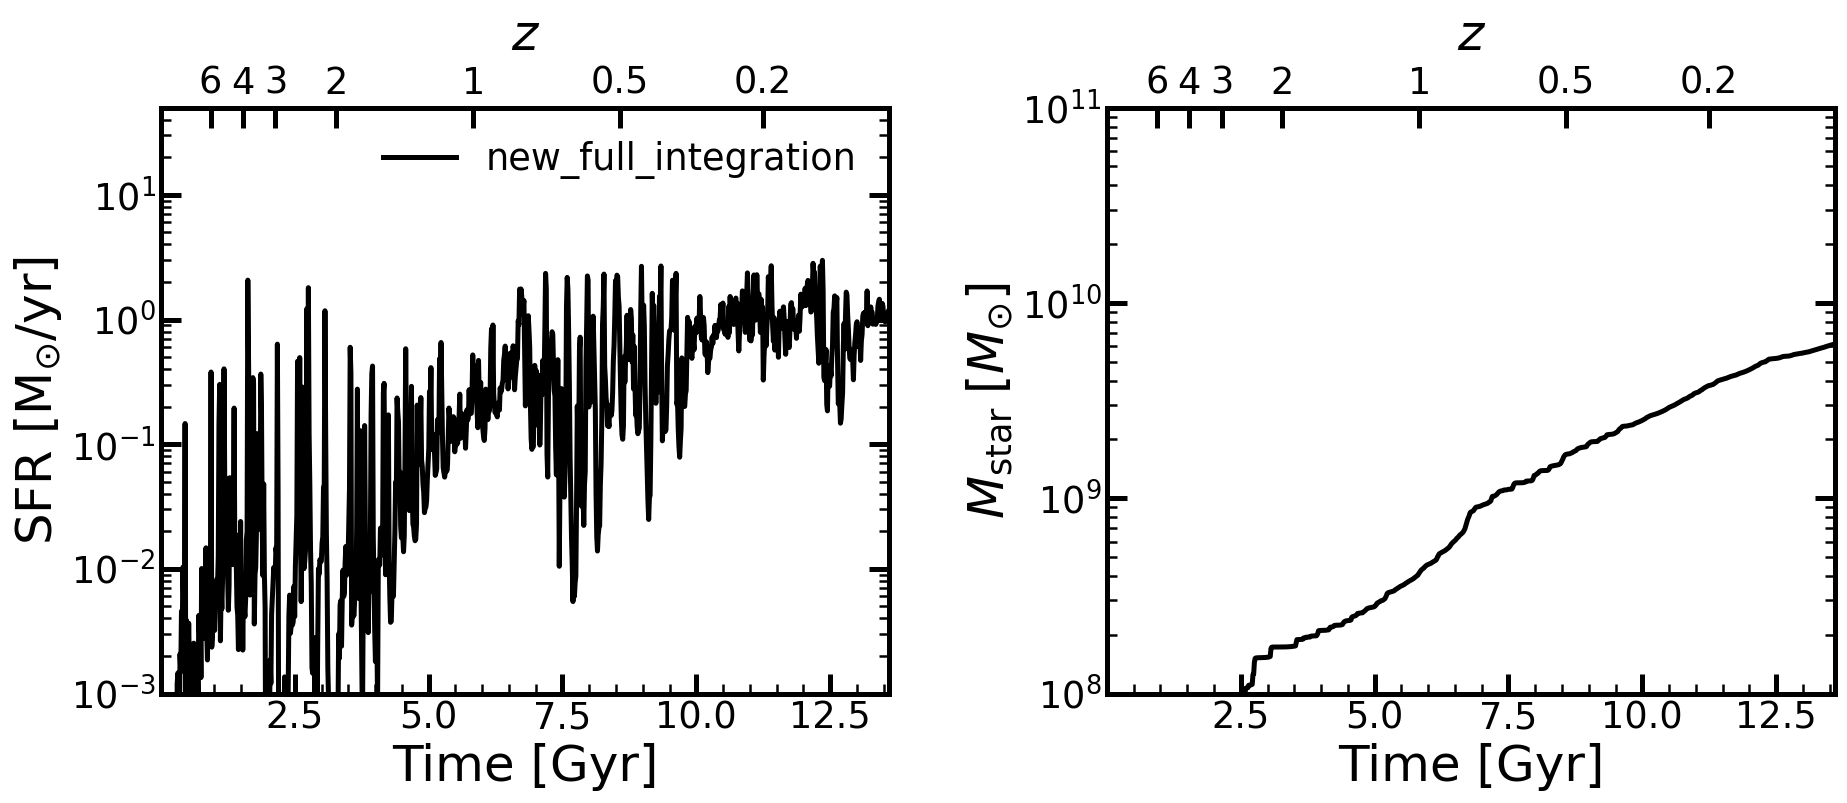

In [19]:
fig = Figure(2,ncols=2)
fig.set_axis(0, 'time', 'sfr')
fig.set_axis(1, 'time', 'M_star')
for k,galaxy in enumerate(galaxies):
    t, sfr = galaxy.get_SFH()
    fig.plot_line_data(0, t, sfr,label=sim_names[k])
    t, Mstar = galaxy.get_SFH(cum=1)
    fig.plot_line_data(1, t, Mstar,label=sim_names[k])
    
fig.set_all_legends()
fig.save(plot_dir+'galaxy_'+str(snap_num)+'_sfh.png')

### Phase Historgram

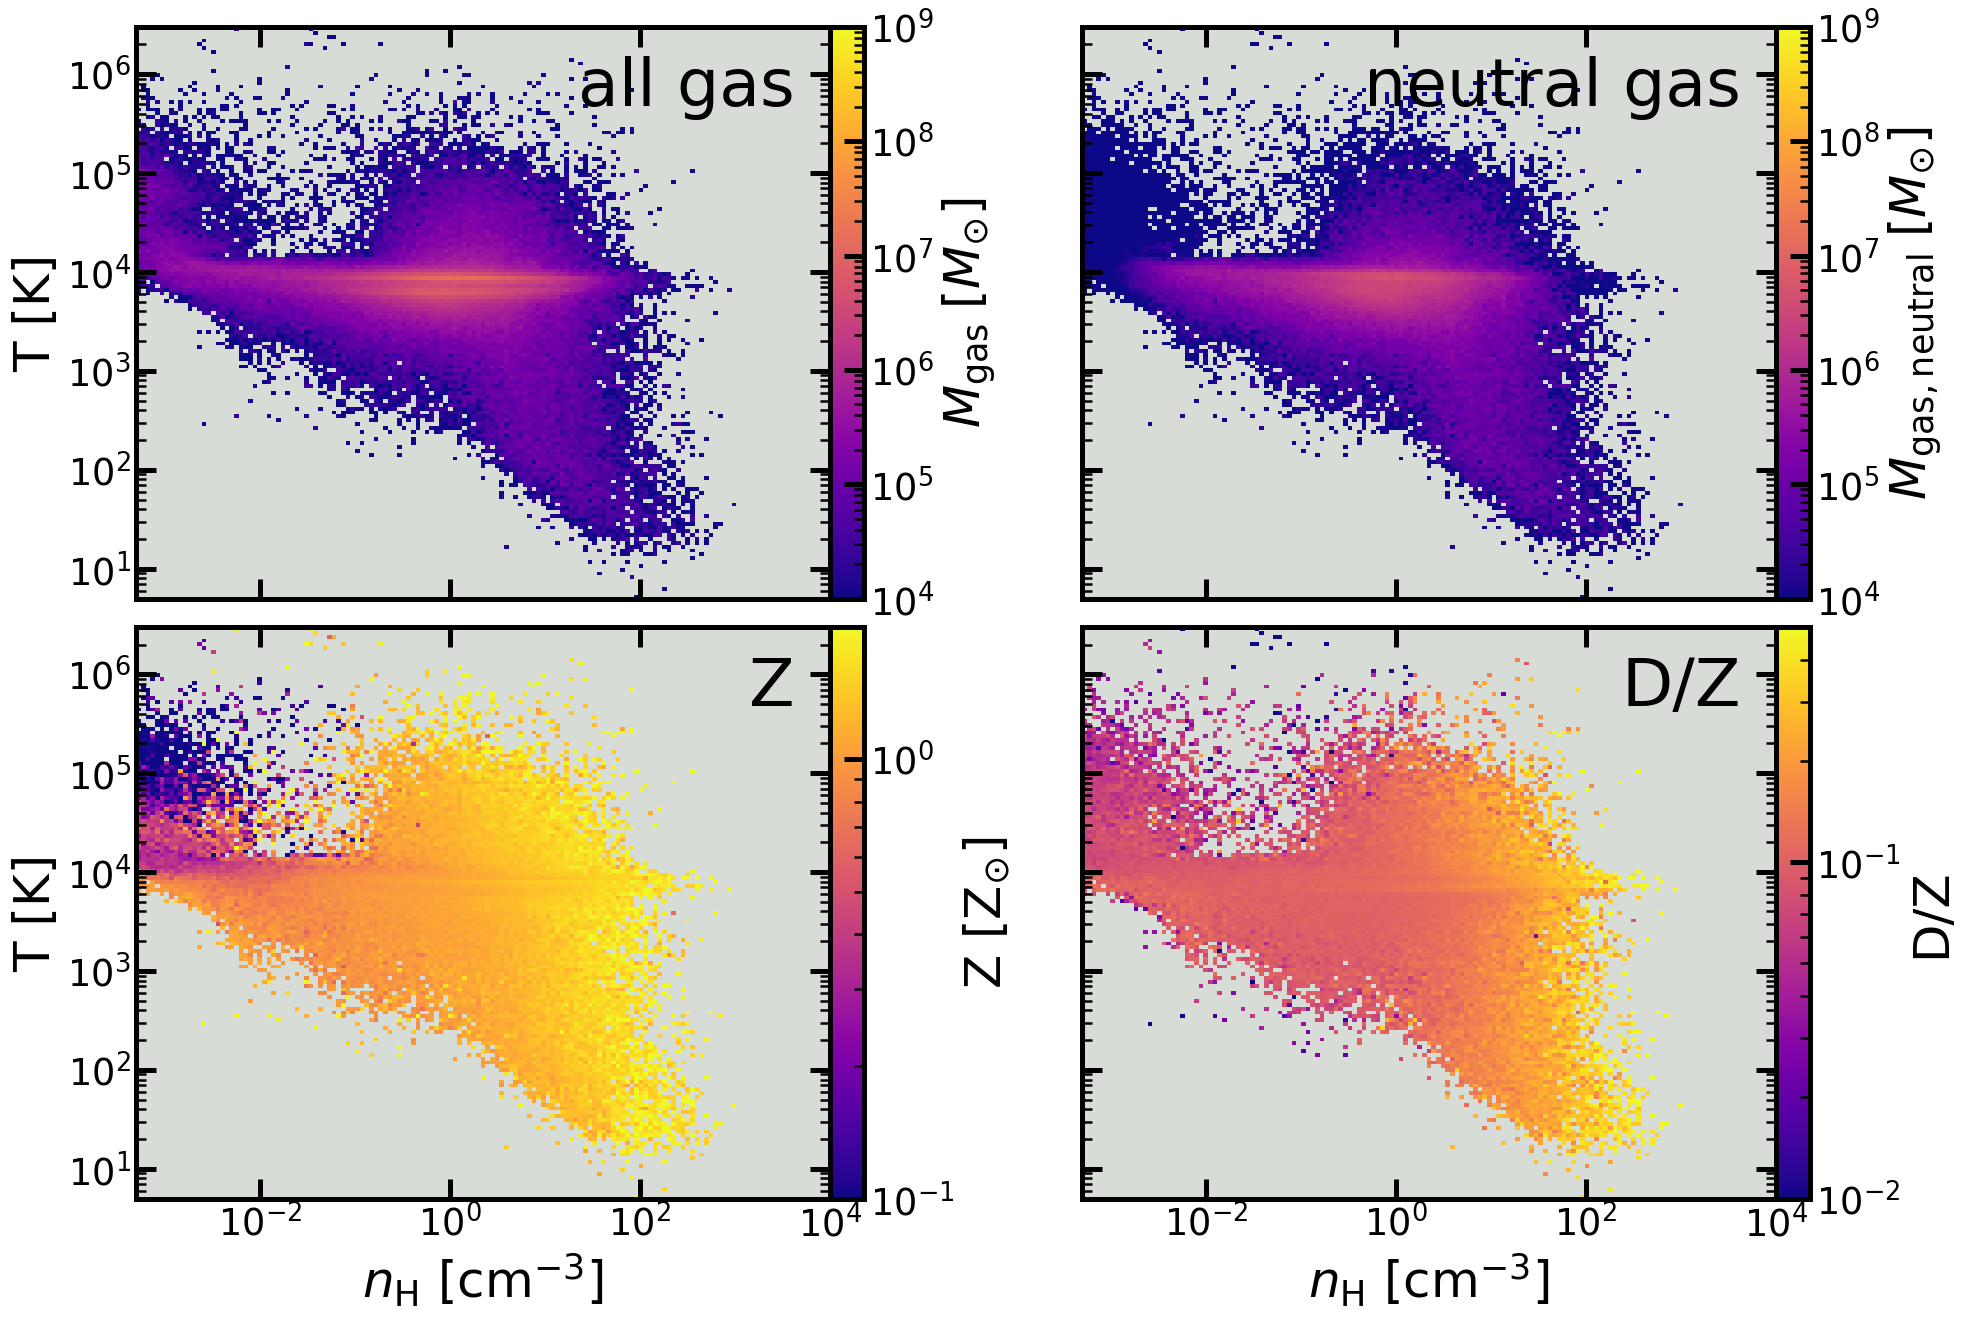

In [31]:
foutname='metals&dust_gas_phase.png'
# Property to bin in phase diagram
props = ['M_gas','M_gas_neutral','Z','D/Z']
fig_labels = ['all gas','neutral gas','Z','D/Z']
z_logs=[True]*len(props)
# Number of bins across nH and T space
bin_nums = 150
cmap='plasma'
# nH and T limits
nH_lims = [5E-4,1E4]
T_lims = [5,3E6]

prop_lims=[[1E4,1E9],[1E4,1E9],[0.1,2],[0.01,0.5]]

for i, snap in enumerate(galaxies):
    name = sim_names[i]
    # Setup figure
    fig = Figure(len(props),ncols=2, sharex='col',sharey='row')

    for j,prop in enumerate(props):
        # Set up for each plot
        fig.set_axis(j, 'nH', 'T', x_lim=nH_lims, x_log=True, y_lim=T_lims, y_log=True, face_color='xkcd:light grey')
        ret = calc.calc_phase_hist_data(prop, snap, bin_nums=bin_nums, nH_lims=nH_lims, T_lims=T_lims)
        X, Y = np.meshgrid(ret.x_edge, ret.y_edge)
        fig.plot_histogram(j, prop, X, Y, ret.statistic.T, cmap=cmap, z_lim=prop_lims[j], z_log=z_logs[j],label=fig_labels[j])

        # Add colorbar to last axis
        fig.add_colorbar(j,cbar_prop=prop)

    fig.save(plot_dir+name+'_'+foutname)

### Projection of Stars, Gas, and Dust

Projection size: 10.000 kpc


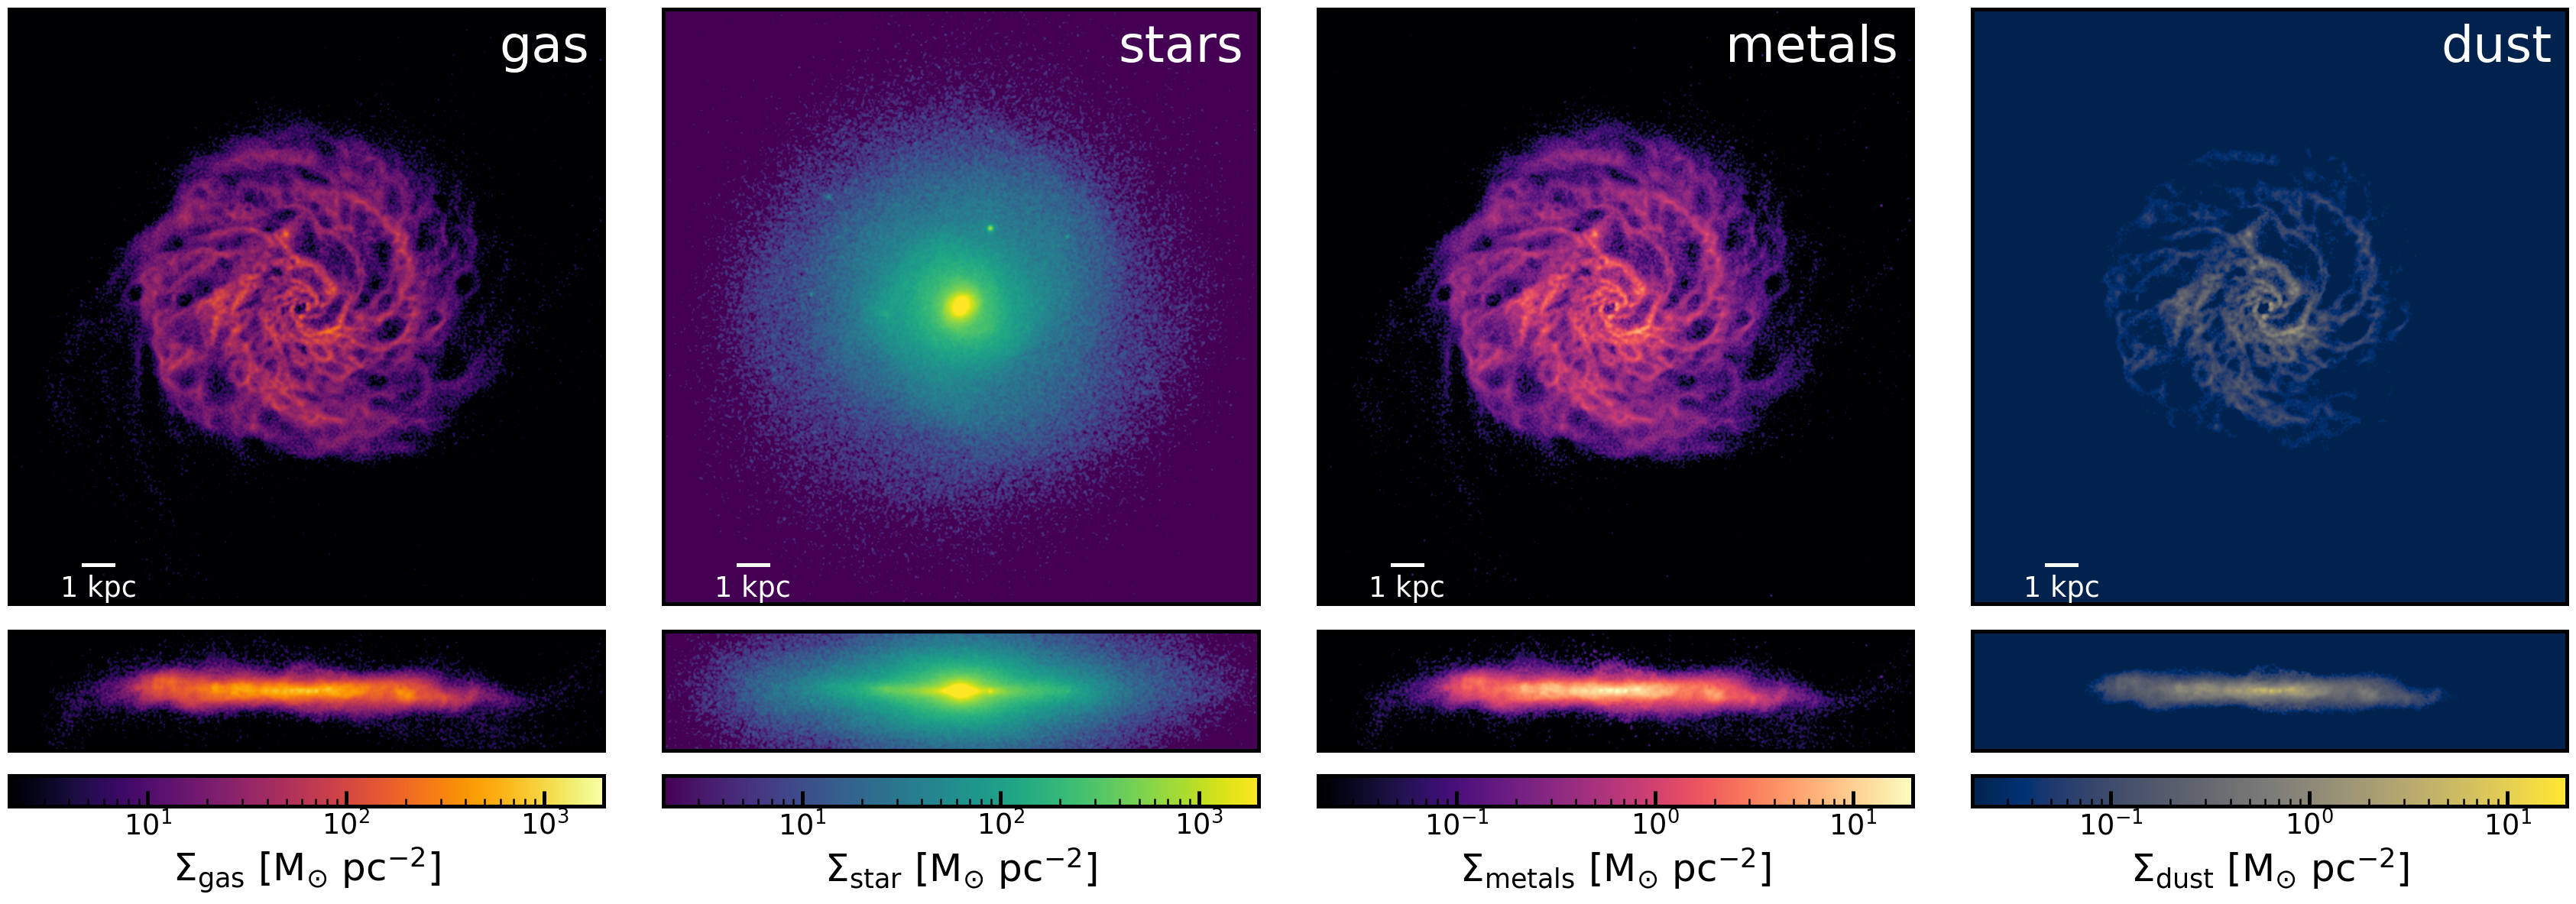

In [39]:
# Properties to plot projections of. Can be surface densities (total mass in pixel divied by pixel size) or properties like T (median value of all particles in pixel)
properties = ['sigma_gas','sigma_star','sigma_metals','sigma_dust']
# Limits for projection of each property. Defaults if not set
prop_limits = [[2E0,2E3],[2E0,2E3],[2E-2,2E1],[2E-2,2E1]]
# Colormaps for each projection
prop_cmaps = ['inferno','viridis','magma','cividis']
# Do you want log colormaps (default = yes)
log_cmap = [True]*len(properties)
# Labels for each projection is so desired
labels = ['gas','stars','metals','dust']
# Physical size of projection
if mode =='AHF':
    size = 0.2
    rvir_frac = False
else:
    size = 10
    rvir_frac = False
# Do you want a secondary projection from an orthogonal axis?
sub_proj = True
# size of secondary projection
sub_L = 2 # kpc
# Do you want colorbars for each projection?
has_colorbars = True
# Size resolution (kpc) for each "pixel" in projection
pixel_res = 0.05

# Saved image name
foutname='snap_projection.png'

for i,snap in enumerate(galaxies):
    # Initialize projection figure
    if rvir_frac:
        L = size*snap.rvir
    else:
        L=size
    height_ratios = [L/sub_L,1] if sub_proj else [1,1]
    new_proj = Projection(len(properties), sub_proj=sub_proj, has_colorbars=has_colorbars, height_ratios=height_ratios)
    # Create projections for each property and plot the projection
    print('Projection size: %.3f kpc'%L)
    for j,prop in enumerate(properties):
        new_proj.set_axis(j, prop, L, axes_visible=False)
        # x-y projection
        main_pixel_stats, main_xedges, main_yedges, main_extent = calc.calc_projected_prop(prop, snap, [L,L,L], pixel_res=pixel_res, proj='xy')
        if sub_proj:
            # Create x-z subprojection using a 2D histogram
            sub_pixel_stats, sub_xedges, sub_yedges, sub_extent = calc.calc_projected_prop(prop, halo, [L,sub_L,L], pixel_res=pixel_res, proj='xz')
        #sub_pixel_stats, sub_xedges, sub_yedges, sub_extent = calc.calc_projected_prop(prop, snap, [L,sub_L,L], pixel_res=pixel_res, proj='xz')
        new_proj.plot_projection(j, main_pixel_stats, main_extent, sub_proj_data=sub_pixel_stats, sub_extent=sub_extent,
                                 cmap= prop_cmaps[j], v_limits = prop_limits[j],v_log=log_cmap[j], label=labels[j])

    new_proj.save(plot_dir+sim_names[i]+'_'+foutname)

### Next